In [32]:
import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [8]:
# Cargar el archivo JSON desde el enlace externo
url = 'https://www.datos.gov.co/resource/w9zh-vetq.json'
response = requests.get(url)
data_json = response.json()

In [9]:
# Crear un DataFrame con los datos
df = pd.DataFrame(data_json)

In [10]:
# Seleccionar columnas relevantes y corregir nombres
df = df.rename(columns={
    'tasa_efectiva_promedio': 'tasa_interes_promedio',
    'tipo_entidad': 'tipo_entidad_financiera',
    'tipo_de_cr_dito': 'tipo_credito',
    'tipo_de_garant_a': 'tipo_garantia',
    'producto_de_cr_dito': 'producto_credito',
    'plazo_de_cr_dito': 'plazo_credito',
})

In [11]:
# Eliminar columnas no numéricas o no relevantes
cols_to_drop = ['nombre_tipo_entidad', 'nombre_entidad', 'fecha_corte', 'tipo_de_persona', 'sexo', 'tama_o_de_empresa',
                'grupo_etnico', 'antiguedad_de_la_empresa', 'tipo_de_tasa', 'rango_monto_desembolsado', 'clase_deudor',
                'codigo_ciiu', 'codigo_municipio']
df = df.drop(cols_to_drop, axis=1)

In [12]:
# Manejar valores no numéricos en columnas categóricas
categorical_cols = ['tipo_entidad_financiera', 'tipo_credito', 'tipo_garantia', 'producto_credito']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')  # Llenar valores nulos con 'Unknown'
    df[col] = LabelEncoder().fit_transform(df[col])  # Codificar las categorías como números

In [13]:
# Seleccionar solo las columnas numéricas para la normalización
numeric_cols = ['tasa_interes_promedio', 'montos_desembolsados', 'numero_de_creditos']
X = df[numeric_cols]

In [14]:
# Normalización de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Función para actualizar el gráfico interactivo
def update_plot(num_clusters):
    # Aplicar KMeans con el número de clusters especificado
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)

    # Agregar la columna de clusters al DataFrame
    df['Cluster'] = clusters

    # Crear el gráfico interactivo
    fig = go.Figure()
    for cluster in range(num_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        fig.add_trace(go.Scatter(x=cluster_data['tasa_interes_promedio'], y=cluster_data['montos_desembolsados'], mode='markers', name=f'Cluster {cluster}'))

    fig.update_layout(title=f'Clustering with {num_clusters} clusters', xaxis_title='Tasa de Interés Promedio', yaxis_title='Montos Desembolsados')
    fig.show()

# Crear el gráfico interactivo inicial con 3 clusters
update_plot(3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
# Aplicar KMeans para clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [17]:
# Agregar la columna de clusters al DataFrame
df['cluster'] = clusters

In [18]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, clusters, test_size=0.2, random_state=42)

In [19]:
# Definir el modelo de red neuronal
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Capa de salida con 3 neuronas para los clusters
])


In [20]:
# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=1)


Epoch 1/100
20/20 [==============================] - 2s 20ms/step - loss: 0.5590 - accuracy: 0.7859 - val_loss: 0.8293 - val_accuracy: 0.9750
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1675 - accuracy: 0.9688 - val_loss: 0.6589 - val_accuracy: 0.9688
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1082 - accuracy: 0.9781 - val_loss: 0.5519 - val_accuracy: 0.9688
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1759 - accuracy: 0.9656 - val_loss: 0.5124 - val_accuracy: 0.9688
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1228 - accuracy: 0.9797 - val_loss: 0.4278 - val_accuracy: 0.9688
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1311 - accuracy: 0.9719 - val_loss: 0.3686 - val_accuracy: 0.9625
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0844 - accuracy: 0.9812 - val_loss: 0.3184 - val_accuracy: 0.9688
Epoch 8/100


In [23]:
# Evaluar el modelo
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Accuracy: {accuracy}')

7/7 [==============================] - 1s 4ms/step - loss: 0.0090 - accuracy: 1.0000
Accuracy: 1.0


In [24]:
# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 [==============================] - 0s 3ms/step


In [25]:
# Calcular la Coeficiente de Silueta
silhouette = silhouette_score(X_test, y_pred_classes)
print(f'Coeficiente de Silueta: {silhouette}')

Coeficiente de Silueta: 0.7957978656649093


In [26]:
# Calcular el Índice Davies-Bouldin
davies_bouldin = davies_bouldin_score(X_test, y_pred_classes)
print(f'Índice Davies-Bouldin: {davies_bouldin}')

Índice Davies-Bouldin: 0.16971763442906243


In [27]:
# Crear un DataFrame con las predicciones y los verdaderos valores
results_df = pd.DataFrame({'Predicted': y_pred_classes, 'True': y_test})

In [28]:
# Gráfico interactivo de dispersión para visualizar las predicciones vs los valores reales
fig_scatter = go.Figure()
fig_scatter.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], mode='markers', name='Predicted', marker_color='blue'))
fig_scatter.add_trace(go.Scatter(x=results_df.index, y=results_df['True'], mode='markers', name='True', marker_color='red'))
fig_scatter.update_layout(title='Scatter Plot of Predicted vs True Labels', xaxis_title='Sample Index', yaxis_title='Cluster')

In [29]:
# Mostrar los gráficos interactivos
fig_histogram = go.Figure()
fig_histogram.add_trace(go.Histogram(x=clusters, marker_color='green'))
fig_histogram.update_layout(title='Cluster Distribution', xaxis_title='Cluster', yaxis_title='Count')
fig_histogram.show()

In [30]:
# Filtrar el DataFrame original por cada cluster
cluster_0_data = df[df['cluster'] == 0]
cluster_1_data = df[df['cluster'] == 1]
cluster_2_data = df[df['cluster'] == 2]

# Mostrar los datos de cada cluster
print("Datos del Cluster 0:")
print(cluster_0_data.head())  # Muestra las primeras filas del Cluster 0

print("\nDatos del Cluster 1:")
print(cluster_1_data.head())  # Muestra las primeras filas del Cluster 1

print("\nDatos del Cluster 2:")
print(cluster_2_data.head())  # Muestra las primeras filas del Cluster 2

Datos del Cluster 0:
    tipo_entidad_financiera codigo_entidad  tipo_credito  tipo_garantia  \
1                         0              1             2              3   
2                         0              7             2              3   
17                        0             39             2              3   
18                        0              7             2              0   
25                        0              7             0              3   

    producto_credito      plazo_credito tasa_interes_promedio  \
1                 23  Consumos a un mes                     0   
2                 24  Consumos a un mes                     0   
17                24  Consumos a un mes                     0   
18                24  Consumos a un mes                     0   
25                22  Consumos a un mes                     0   

   margen_adicional_a_la montos_desembolsados numero_de_creditos  Cluster  \
1                      0                25190               

<Figure size 1000x600 with 0 Axes>

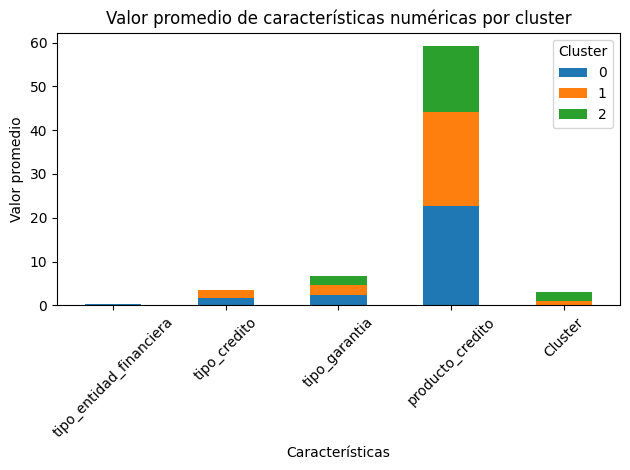

In [33]:
# Excluir las columnas no numéricas
numeric_df = df.select_dtypes(include=np.number)

# Calcular las medias de cada característica por cluster
cluster_means = numeric_df.groupby('cluster').mean()

# Transponer los datos para facilitar la visualización
cluster_means_transposed = cluster_means.T

# Graficar las características por cluster
plt.figure(figsize=(10, 6))
cluster_means_transposed.plot(kind='bar', stacked=True)
plt.xlabel('Características')
plt.ylabel('Valor promedio')
plt.title('Valor promedio de características numéricas por cluster')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
